Курсовой проект по курсу "Машинное обучение. Часть 2".

Проект выполнен **Кузиной Е.А., гр. М21-524**, НИЯУ МИФИ

## Предсказание наличия заболеваний сердца

План работы:  
1. Предварительный анализ + предобработка данных
2. Определение факторных признаков
3. Классификация

## Предварительный анализ и предобработка данных

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/heart.csv')

In [ ]:
df.head(5)

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
for index, row in df.groupby(df.HeartDisease).count().iterrows():
  print(f'Нет заболевания:\t{row["Age"]} чел.' if index == 0 \
        else f'Есть заболевание:\t{row["Age"]} чел.')

Нет заболевания:	410 чел.
Есть заболевание:	508 чел.


Разделение признаков на качественные и количественные

In [ ]:
categories = []
for col in df.columns[df.dtypes == 'object']:
  categories.append(col)

In [ ]:
quantitative = df.drop(categories, axis=1)
quantitative = quantitative.drop(['HeartDisease', 'FastingBS'], axis=1)
result = df.HeartDisease
# qualitative =

In [ ]:
quantitative.describe().T

count        mean         std   min     25%    50%    75%    max
Age          918.0   53.510893    9.432617  28.0   47.00   54.0   60.0   77.0
RestingBP    918.0  132.396514   18.514154   0.0  120.00  130.0  140.0  200.0
Cholesterol  918.0  198.799564  109.384145   0.0  173.25  223.0  267.0  603.0
MaxHR        918.0  136.809368   25.460334  60.0  120.00  138.0  156.0  202.0
Oldpeak      918.0    0.887364    1.066570  -2.6    0.00    0.6    1.5    6.2

Кодирование качетсвенных признаков

In [ ]:
for cat in categories:
  print(cat if cat !='Sex' else cat+'\t', df[cat].unique(), sep='\t')

Sex		['M' 'F']
ChestPainType	['ATA' 'NAP' 'ASY' 'TA']
RestingECG	['Normal' 'ST' 'LVH']
ExerciseAngina	['N' 'Y']
ST_Slope	['Up' 'Flat' 'Down']


In [ ]:
# encoding
for cat in categories:
  vals = {}
  for i,val in enumerate(df[cat].unique()):
    vals[val] = i
  df[cat] = df[cat].apply(lambda x: vals[x])

for cat in categories:
  print(cat if cat !='Sex' else cat+'\t', df[cat].dtype, df[cat].unique(), sep='\t')

Sex		int64	[0 1]
ChestPainType	int64	[0 1 2 3]
RestingECG	int64	[0 1 2]
ExerciseAngina	int64	[0 1]
ST_Slope	int64	[0 1 2]


In [ ]:
qualitative = df[categories]
qualitative.insert(loc=3, column='FastingBS', value=df['FastingBS'].values)

Корреляция с качественных порядковых и количественных признаков

In [ ]:
tmp_corr_df = quantitative.join(df[['FastingBS', 'ExerciseAngina']])

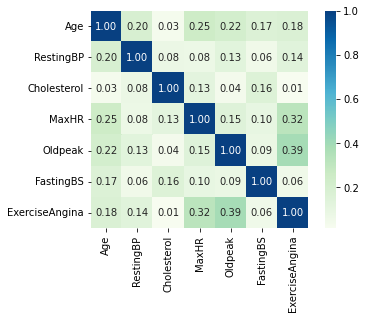

In [ ]:
sns.heatmap(tmp_corr_df.corr('kendall').apply(lambda x: abs(x)).T,  annot=True, square=True, fmt= ".2f", cmap="GnBu")
None

Парные распределения, цвет - признак наличия болезни

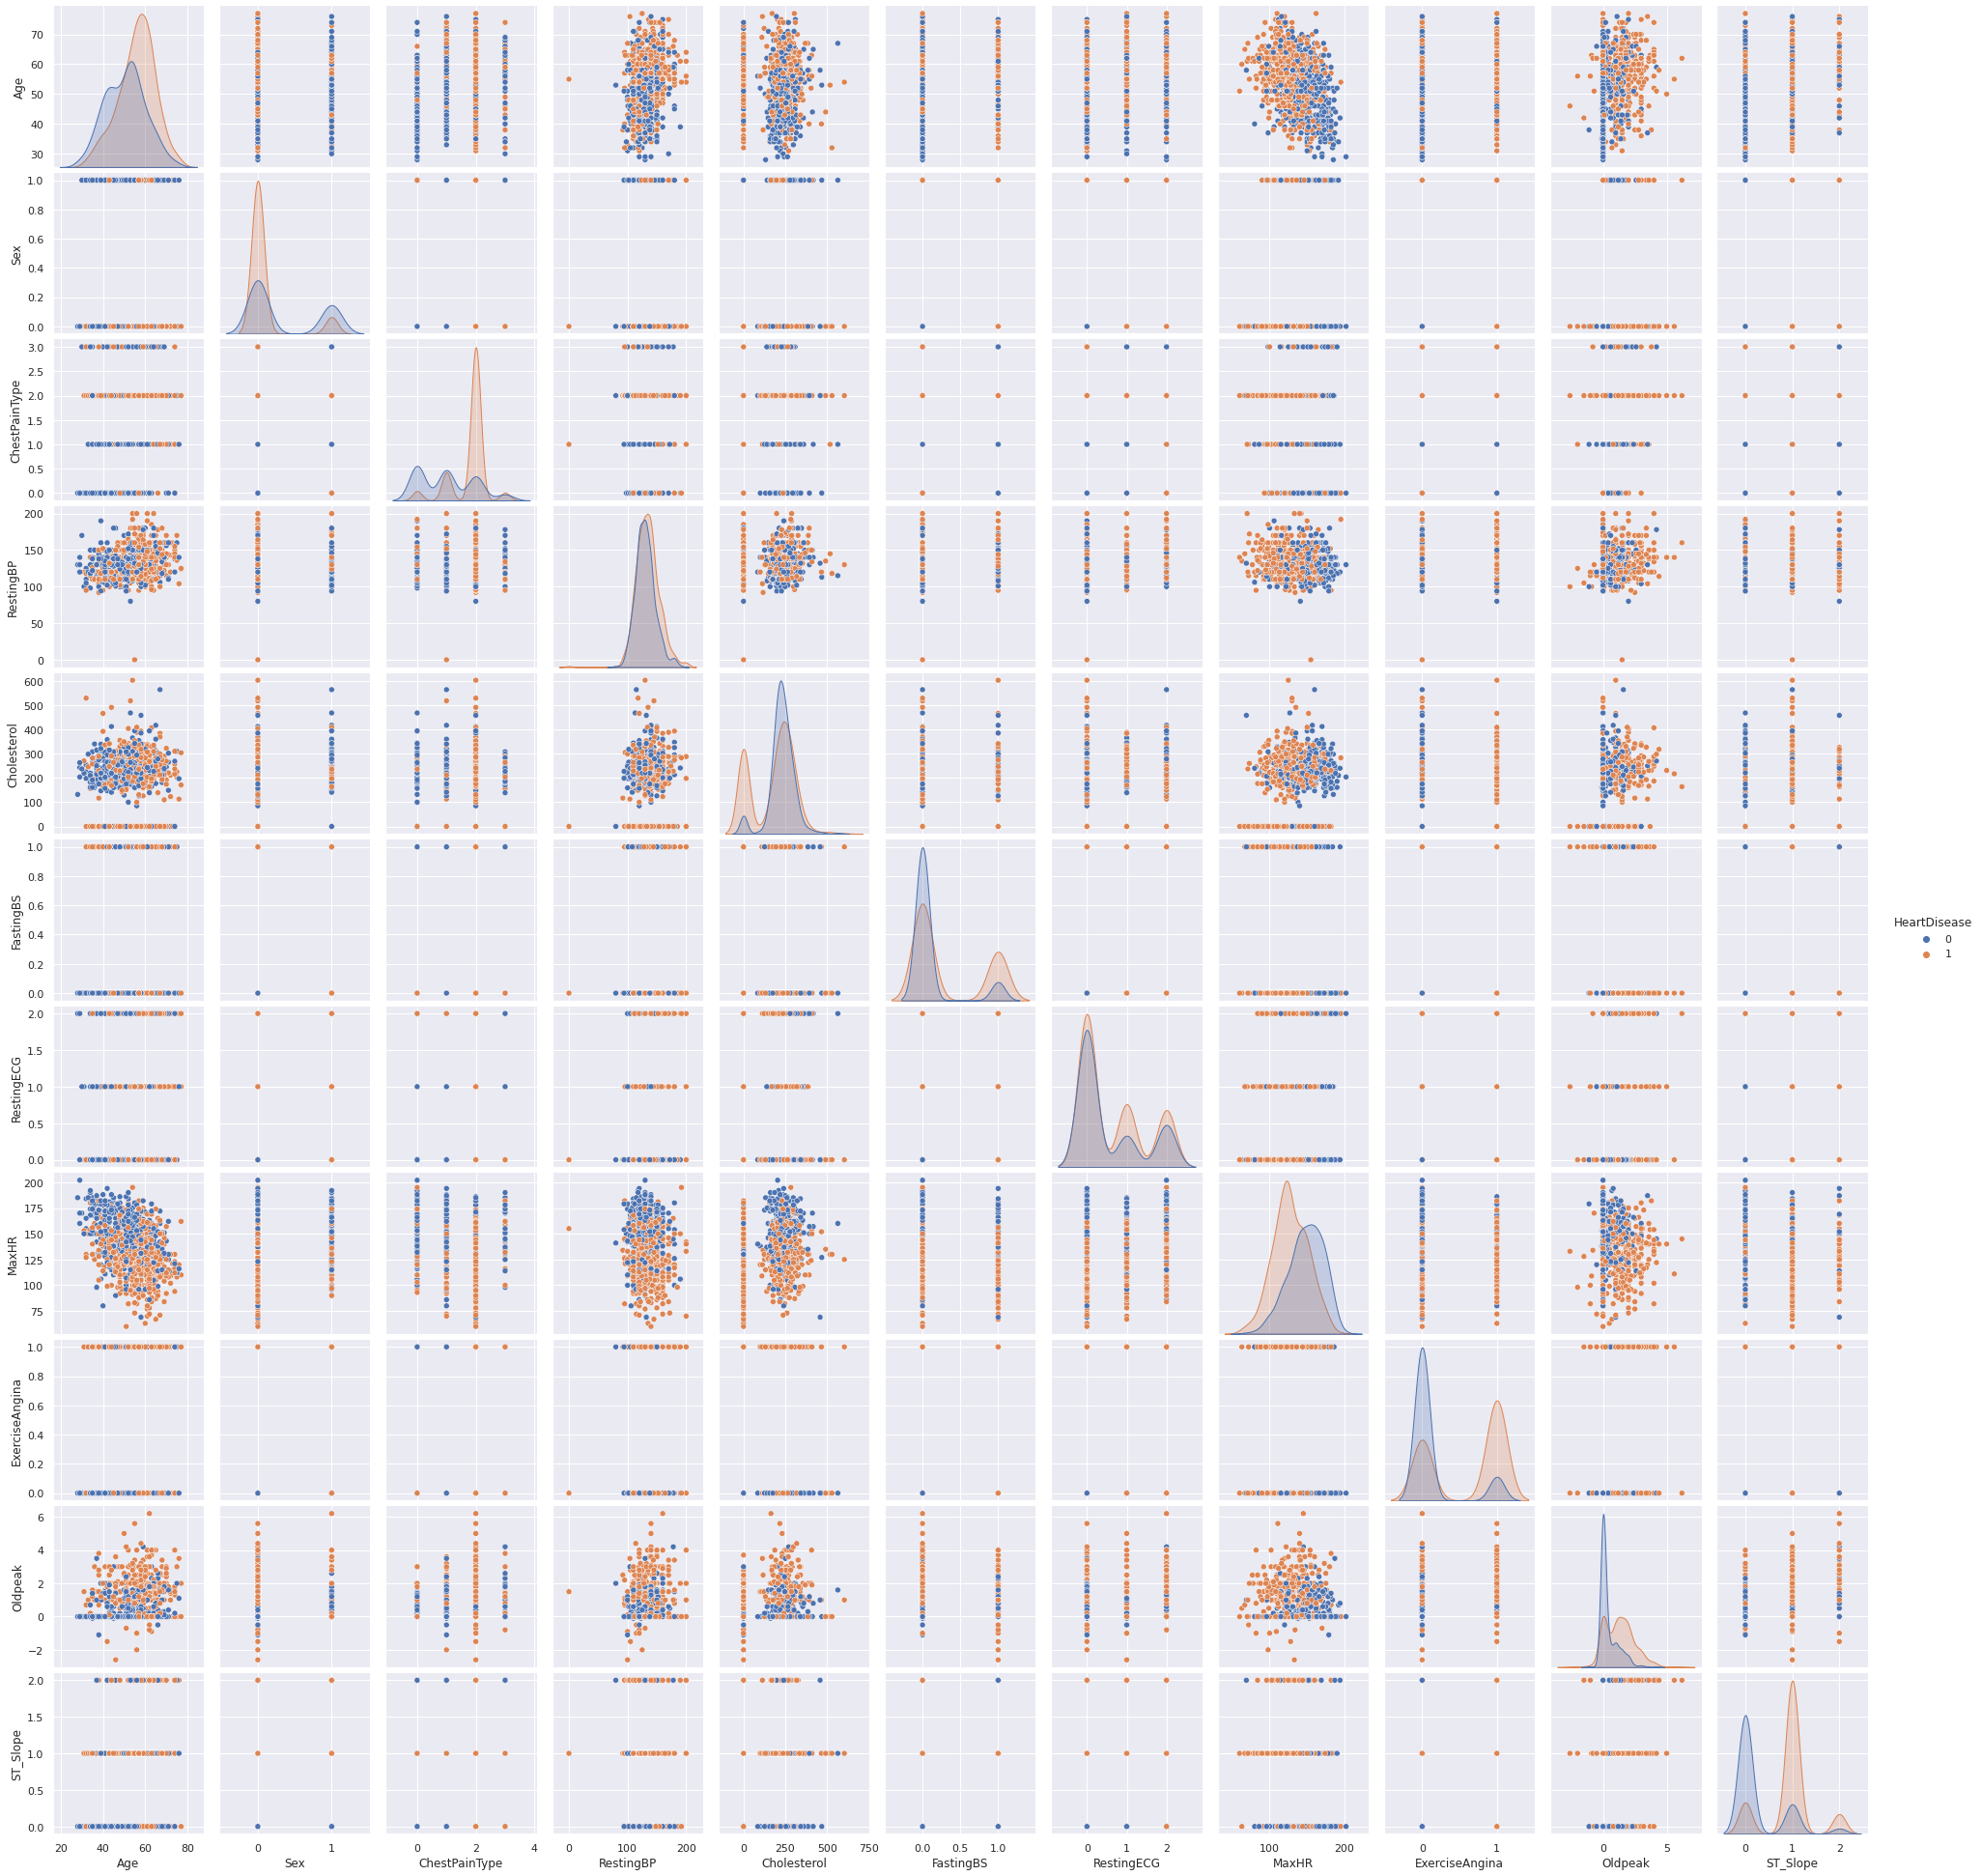

In [ ]:
sns.set(rc={'figure.figsize':(12,8.5)})
sns.pairplot(df, hue="HeartDisease")

Проверим зависимость наличия заболевания от RestingBP

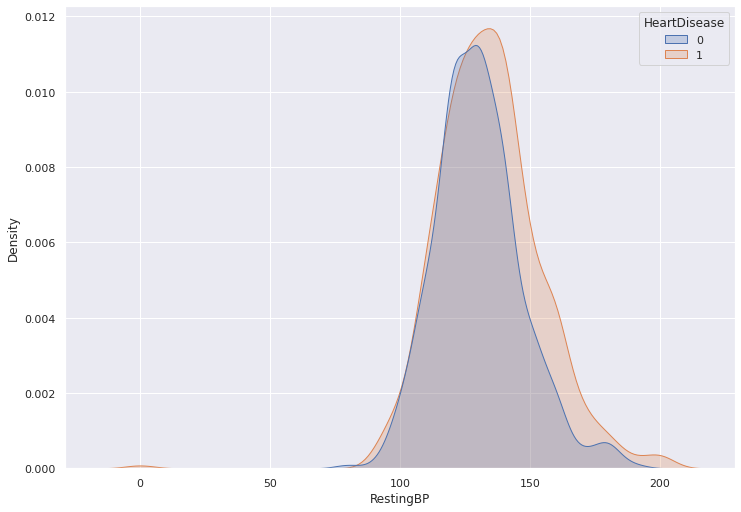

In [ ]:
sns.kdeplot(data=df, x='RestingBP', hue='HeartDisease', fill=True)

In [ ]:
from scipy.stats import mannwhitneyu as MWh

In [ ]:
p_value = MWh(x = df.loc[df['HeartDisease']==0]['RestingBP'].values, y=df.loc[df['HeartDisease']==1]['RestingBP'].values)[1]
if p_value < 0.05: print('Выборки однородны')
else: print('Выборки неоднородны')


Выборки однородны


Различие выборок давления в покое (RestingBP) при наличии/отсутствии заболевания статистически незначимы. Кроме того, двумерные распределения давления в покое с другими показателями не дает визуального разделения между наличием и отсутствием заболевания.

Вывод: исключим RestingBP из дальнейшего рассмотрения.

In [ ]:
df = df.drop('RestingBP', axis=1)
quantitative = quantitative.drop('RestingBP', axis=1)

Детальнее посмортим на Oldpeak

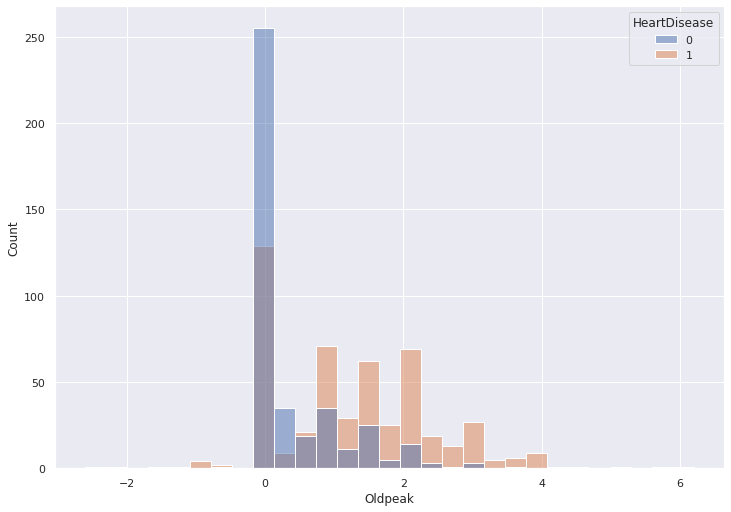

In [ ]:
sns.histplot(data=df, x='Oldpeak', hue='HeartDisease', fill=True)

In [ ]:
oldpeak_div_good = len(df.loc[(df['Oldpeak'] == 0) & (df['HeartDisease'] == 0)])/len(df.loc[(df['HeartDisease'] == 0)])
oldpeak_div_bad = len(df.loc[(df['Oldpeak'] == 0) & (df['HeartDisease'] == 1)])/len(df.loc[(df['HeartDisease'] == 1)])
print(oldpeak_div_good, oldpeak_div_bad)

0.5951219512195122 0.2440944881889764


Не понятно, но очень интересно. Сложно считать значением-заполнителем, т.к. отношения к общему числу сильно разные

Посмотрим на холестерин

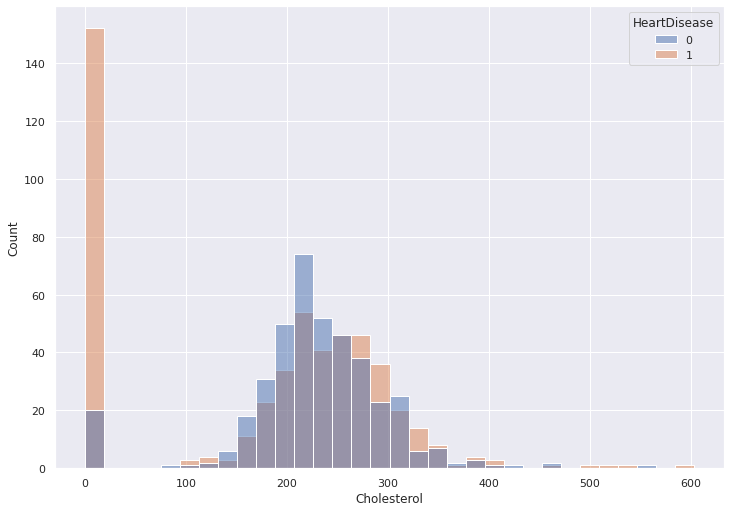

In [ ]:
sns.histplot(data=df, x='Cholesterol', hue='HeartDisease', fill=True)

Аналогично...

Построим распределения всех характеристик против признака наличия заболевания

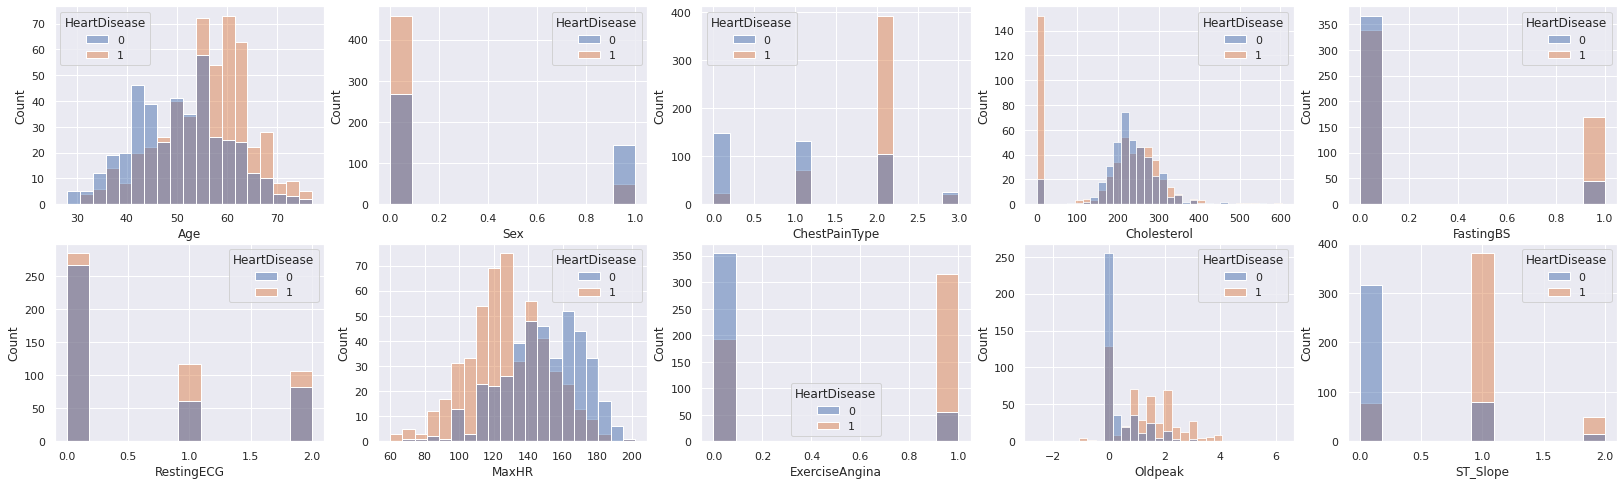

In [ ]:
fig, axes = plt.subplots(2,5, figsize=(28,8))
axs = axes.flatten()
for i, col in enumerate(df.columns):
  if col == 'HeartDisease': continue

  sns.histplot(data=df, ax=axs[i], x=col, hue='HeartDisease')


Выводы на основе представленных гистограмм:
 - В возрасте 55-65 лет характерно наличие заболеваний
 - Отсутствие заболеваний характернее для женщин
 - При боли типа "нестенокардическая" характерно наличие заболевания
 - При боли типа "типичная стенокардия" не характерно наличие заболевания
 - При высоком уровене сахара в крови характерно наличие заболеваний
 - При стенокардии в результате нагрузки характерно наличие заболеваний
 - При восходящем ST сегменте ЭКГ характерно отсутствие заболеваний
 - При плоском и нисходящем ST сегменте ЭКГ характерно наличие заболеваний
 - Сложно проанализировать результаты ЭКГ в покое и максимальную ЧСС в отношении наличия заболеваний

## Факторный анализ

In [ ]:
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

In [ ]:
df_scaled = pd.DataFrame(data=data_scaled, columns=df.columns)
df_scaled['ST_Slope'].unique()
factors_scaled = df_scaled.drop('HeartDisease', axis=1)

### SVD

In [ ]:
from sklearn.decomposition import TruncatedSVD as svd

In [ ]:
factors = df.drop('HeartDisease', axis=1)

In [ ]:
for i in range(3,22,3):
  svd_ = svd(n_components=9, n_iter = i)
  svd_.fit(factors_scaled)
  print(svd_.explained_variance_ratio_)

[0.135 0.251 0.178 0.142 0.108 0.068 0.052 0.035 0.023]
[0.135 0.251 0.178 0.142 0.108 0.068 0.052 0.035 0.023]
[0.135 0.251 0.178 0.142 0.108 0.068 0.052 0.035 0.023]
[0.135 0.251 0.178 0.142 0.108 0.068 0.052 0.035 0.023]
[0.135 0.251 0.178 0.142 0.108 0.068 0.052 0.035 0.023]
[0.135 0.251 0.178 0.142 0.108 0.068 0.052 0.035 0.023]
[0.135 0.251 0.178 0.142 0.108 0.068 0.052 0.035 0.023]


In [ ]:
svd_ = svd(n_components=9, n_iter = 5)
svd_.fit(factors_scaled)

TruncatedSVD(n_components=9)

In [ ]:
svd_.explained_variance_ratio_

array([0.135, 0.251, 0.178, 0.142, 0.108, 0.068, 0.052, 0.035, 0.023])

Text(0.5, 0, 'Номер компоненты')

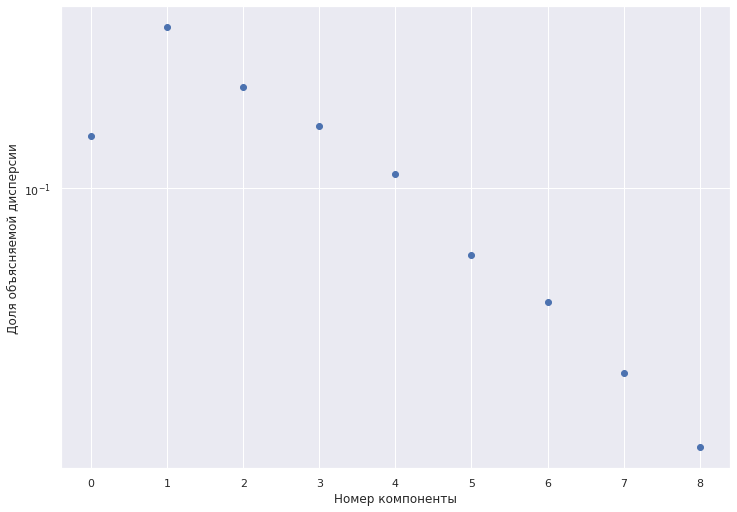

In [ ]:
plt.scatter(range(len(svd_.explained_variance_ratio_)), svd_.explained_variance_ratio_)
plt.yscale('log')
plt.ylabel('Доля объясняемой дисперсии')
plt.xlabel('Номер компоненты')

In [ ]:
svd_.explained_variance_ratio_[:6].sum()

0.8818246137176455

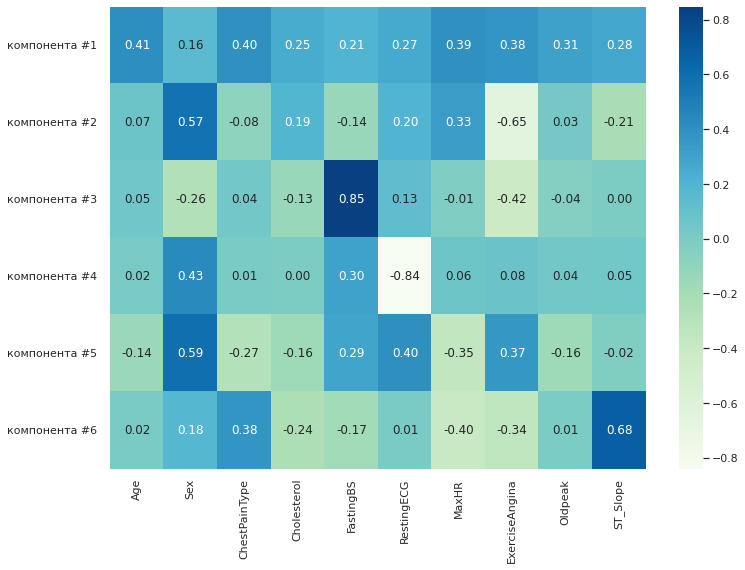

In [ ]:
svd_df = pd.DataFrame(data=svd_.components_[:6,:], columns=factors.columns, index=[f'компонента #{i+1} ' for i in range(0,6)])
sns.heatmap(svd_df, annot=True, fmt= ".2f", cmap="GnBu")

In [ ]:
svd_ = svd(n_components=6, n_iter = 5)
svd_.fit(factors_scaled)
svd_data = svd_.transform(factors_scaled)
svd_data = np.concatenate((svd_data, result.values.reshape(len(result),1)), axis=1)
svd_data.shape

(918, 7)

### TSNE

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.manifold import TSNE

(918, 3)
(918, 3)
(918, 3)


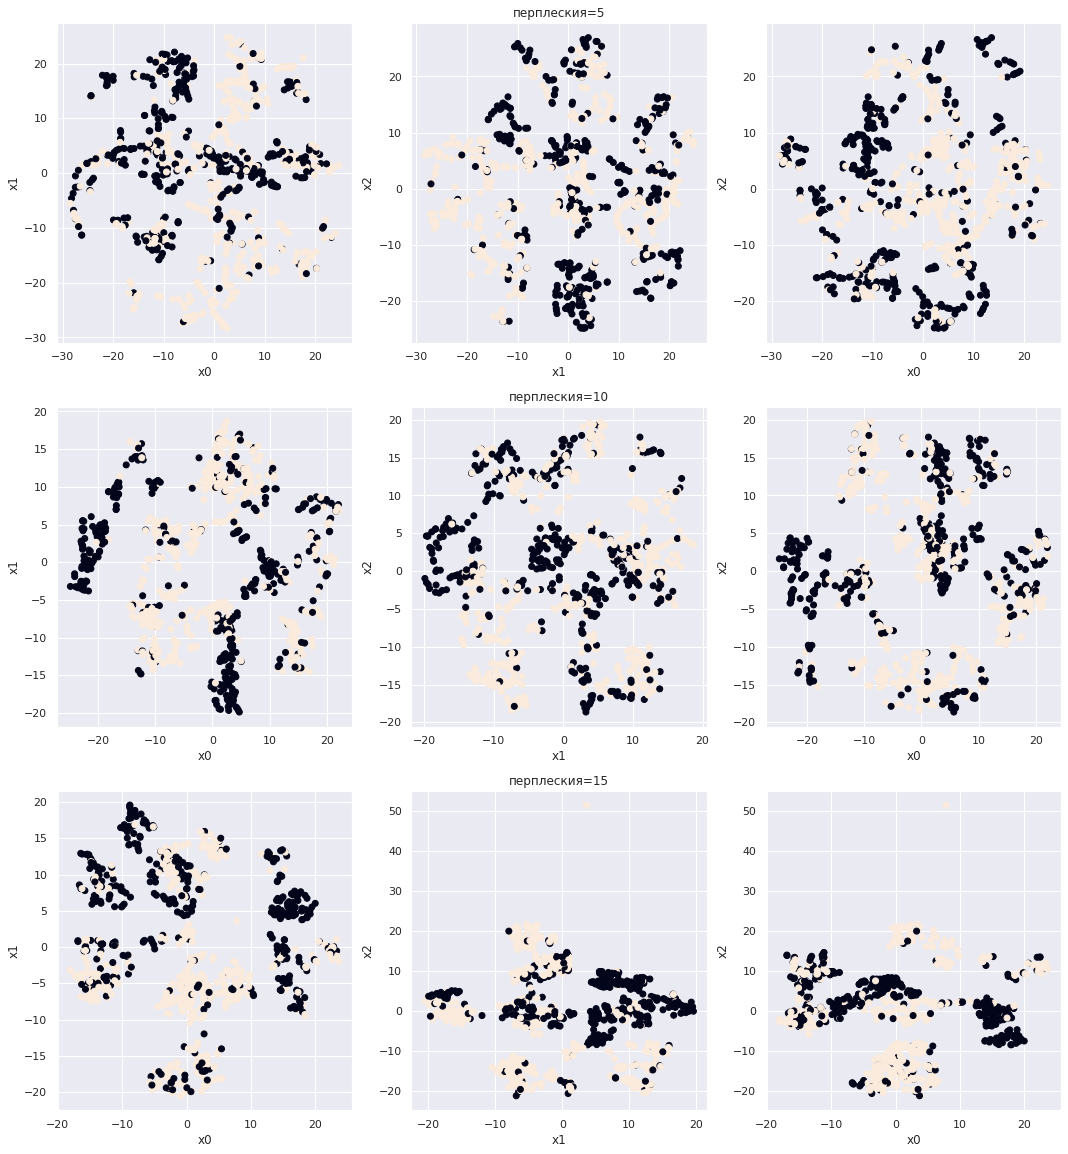

In [ ]:
n_comp_ = 3
perps = [5, 10, 15]
fig, axes = plt.subplots(len(perps),n_comp_,figsize=(18,20))
row = 0
for i,p in enumerate(perps):
  tsne = TSNE(n_components=n_comp_, perplexity=p, n_jobs=2)
  tsne.fit(factors_scaled)
  print(tsne.embedding_.shape)
  axes[i][0].scatter(tsne.embedding_[:,0],tsne.embedding_[:,1], c=df['HeartDisease'])
  axes[i][1].set_title(f'перплеския={p}')
  axes[i][0].set_xlabel('x0')
  axes[i][0].set_ylabel('x1')

  axes[i][1].scatter(tsne.embedding_[:,1],tsne.embedding_[:,2], c=df['HeartDisease'])
  axes[i][1].set_title(f'перплеския={p}')
  axes[i][1].set_xlabel('x1')
  axes[i][1].set_ylabel('x2')

  axes[i][2].scatter(tsne.embedding_[:,0],tsne.embedding_[:,2], c=df['HeartDisease'])
  axes[i][1].set_title(f'перплеския={p}')
  axes[i][2].set_xlabel('x0')
  axes[i][2].set_ylabel('x2')


## Классификация

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import f1_score, accuracy_score

### QDA

In [ ]:
train_data, test_data = train_test_split(svd_data, train_size=0.7, random_state=31)

In [ ]:
clf = QDA(priors=[0.5,0.5])
clf.fit(train_data[:, :-1], train_data[:,-1])

QuadraticDiscriminantAnalysis(priors=array([0.500, 0.500]))

In [ ]:
preds_train = clf.predict(train_data[:, :-1])
preds_test = clf.predict(test_data[:, :-1])

In [ ]:
qda_acc_train = accuracy_score(train_data[:,-1], preds_train)
qda_acc_test = accuracy_score(test_data[:,-1], preds_test)
qda_f_train = f1_score(train_data[:,-1], preds_train)
qda_f_test = f1_score(test_data[:,-1], preds_test)

In [ ]:
qda_vals = [qda_acc_train, qda_acc_test, qda_f_train, qda_f_test, 'QDA']

### LogisticRegression

In [ ]:
clf = LR()
clf.fit(train_data[:, :-1], train_data[:,-1])

LogisticRegression()

In [ ]:
preds_train = clf.predict(train_data[:, :-1])
preds_test = clf.predict(test_data[:, :-1])

In [ ]:
lr_acc_train = accuracy_score(train_data[:,-1], preds_train)
lr_acc_test = accuracy_score(test_data[:,-1], preds_test)
lr_f_train = f1_score(train_data[:,-1], preds_train)
lr_f_test = f1_score(test_data[:,-1], preds_test)

In [ ]:
lr_vals = [lr_acc_train, lr_acc_test, lr_f_train, lr_f_test, 'Logistic regression']

In [ ]:
df_res = pd.DataFrame(data=[qda_vals, lr_vals], columns=['ACC (train)', 'ACC (test)', 'F1 (train)', 'F1 (test)', 'Classifier'])

In [ ]:
df_res

ACC (train)  ACC (test)  F1 (train)  F1 (test)           Classifier
0     0.848910    0.836957    0.864336   0.851485                  QDA
1     0.861371    0.847826    0.879240   0.861842  Logistic regression